# BTC ML/DL Trading strategy

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
from src.Utils import *

## Preliminary data import & handling

In [3]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [4]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [5]:
# Some statistical analysis
df.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,2.136278e+06,2.136278e+06,2.136278e+06,2.136278e+06,2.136278e+06,2.136278e+06,2.136278e+06
mean,1.140431e+03,1.871015e+04,1.875142e+04,1.867531e+04,1.871015e+04,8.959506e+01,1.870998e+04
std,1.615133e+03,1.786562e+04,1.787513e+04,1.785035e+04,1.786564e+04,1.509393e+02,1.786544e+04
min,1.000000e+00,3.149657e+03,3.176910e+03,3.120000e+03,3.151545e+03,1.000000e-04,3.152326e+03
25%,3.170000e+02,7.123990e+03,7.146973e+03,7.109173e+03,7.124021e+03,2.910561e+01,7.123969e+03
50%,6.350000e+02,9.504575e+03,9.520100e+03,9.490330e+03,9.504526e+03,5.089676e+01,9.504545e+03
75%,1.380000e+03,3.223343e+04,3.229500e+04,3.217598e+04,3.223236e+04,9.409524e+01,3.223299e+04
max,8.747800e+04,6.898612e+04,6.902420e+04,6.873400e+04,6.897356e+04,1.040500e+04,6.889405e+04


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [11]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [13]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

In [14]:
df

,Count,Open,High,Low,Close,Volume,VWAP,LogReturns,TimeRange
timestamp,,,,,,,,,
2018-01-01 00:01:00,229,13835.194000,14013.8,13666.11,13850.176000,31.550062,13827.062093,0.000000,5
2018-01-01 00:02:00,235,13835.036000,14052.3,13680.00,13828.102000,31.046432,13840.362591,-0.001595,5
2018-01-01 00:03:00,528,13823.900000,14000.4,13601.00,13801.314000,55.061820,13806.068014,-0.001939,5
2018-01-01 00:04:00,435,13802.512000,13999.0,13576.28,13768.040000,38.780529,13783.598101,-0.002414,5
2018-01-01 00:05:00,742,13766.000000,13955.9,13554.44,13724.914000,108.501637,13735.586842,-0.003137,5
...,...,...,...,...,...,...,...,...,...
2022-01-23 23:56:00,1221,36278.361667,36331.0,36249.00,36293.123333,30.247067,36289.796806,0.000367,4
2022-01-23 23:57:00,1634,36289.681667,36328.0,36230.72,36261.708333,35.647000,36276.229399,-0.000866,4
2022-01-23 23:58:00,1570,36262.841667,36319.0,36230.30,36276.223333,49.867700,36274.441548,0.000400,4


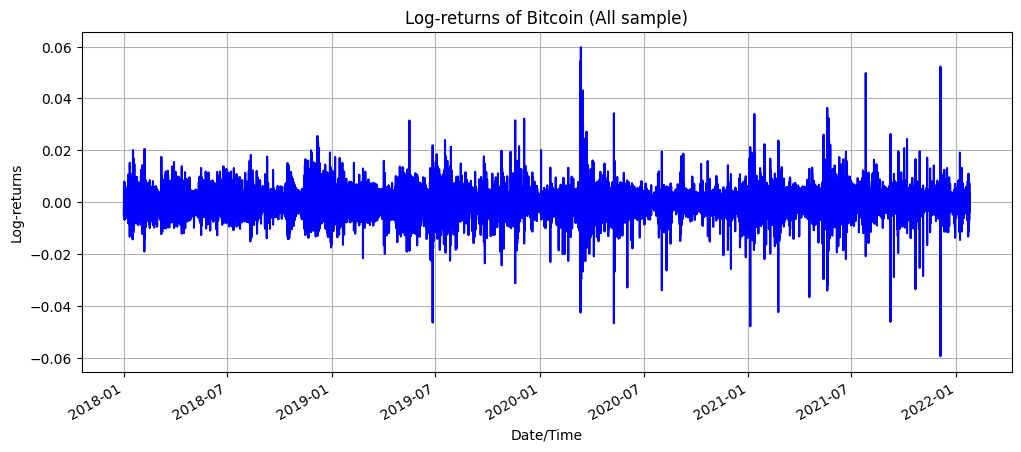

In [7]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

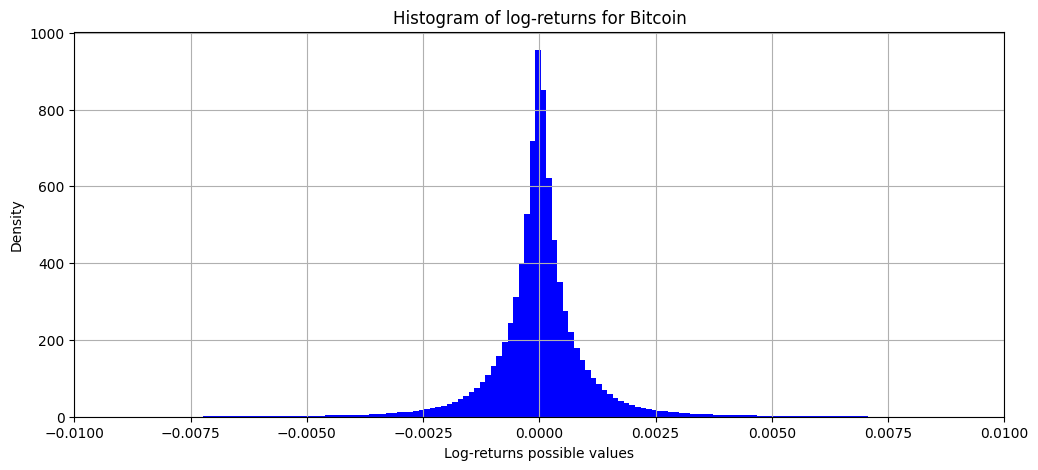

In [21]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.ylabel("Density")

### Technical analysis indicators

In [20]:
# TODO

In [ ]:
# RSI
# Momentum
# Bollinger bands
# Standard deviation
# ...

### Moving averages

In [19]:
# TODO

In [ ]:
# SLOW, MEDIUM, FAST

### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension

## Data pre-processing

In [ ]:
# Computation of the target

In [25]:
# Normalization (see YouTube)

In [ ]:
# X/Y split

In [ ]:
# Train/Test/Validation split